# Sander van de Kamp
#### 500734351 
#### 01/03/2021
# Australian weather rain prediction

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import datetime as dt
import pandas as pd
import numpy as np

# Analysis
### goal
The goal is to predict if it will rain the following day based on the weather conditions of the day before and the location.

### dimensies
The dataset contains 145.000 rows with 23 columns.

### features
Most of the columns in the dataset contain float numbers, the wind directions are all text based and the location and dates are also text.

In [3]:
df = pd.read_csv('weatherAUS.csv')
print(df.head(5))
print(df.dtypes)

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

# Prediction
### Classifier
SVM or Naïve bayes seem like the best models based on the sheer number of features that the dataset has, with SVM seeming like the best due to the higher accuracy compared to other classifiers.
 
### Hyperparams
The hyperparams that can get tweaked in SVMs are the C value and the kernel, where the C value is similar to the logistic regression with lower resulting in stronger regularization. The kernel determines which algorithm should be used to determine the classification, multiple are possible and no kernel specifically results in a higher score. 

In [4]:
svm_params = {
    'C': [0.01, 100],
    'kernel': ['linear', 'sigmoid']
}

# Methods
### Preprocessing
- The main thing that needs to be processed for this dataset is the onehotencoding for the wind directions, where strings are used for wind directions instead of numbers. T
- here are also five columns where nan values are used to either represent a 0 or they're missing (which is not completely clear, so I am filling them with 0's)
- drop rows with nan values, since using a mean still affects the result and there are enough rows that a few missing won't be an issue.
- change the yes/no values to booleans
- split rain tomorrow from df

### Classifiers
SVM and Naive Bayes

### metrics
The most important thing here is to always be right about when it rains, where it doesn't matter as much when it is wrong about it not raining. Rather have cancelled plans than ruined plans due to rain. Which is why recall will be used to score the model.

In [5]:
# drop date
df.drop('Date', axis = 1, inplace = True)

# replace nan values with 0, since nan is used to replace 0 values
df['Evaporation'].fillna(0, inplace = True)
df['Sunshine'].fillna(0, inplace = True)
df['Evaporation'].fillna(0, inplace = True)
df['Cloud9am'].fillna(0, inplace = True)
df['Cloud3pm'].fillna(0, inplace = True)
df.dropna(inplace = True)
# Change rain today and rain tomorrow to boolean (int)
df['RainToday'] = df['RainToday'].replace('No', 0).replace('Yes', 1)
df['RainTomorrow'] = df['RainTomorrow'].replace('No', 0).replace('Yes', 1)

encoder = LabelEncoder()

encoder.fit(df['Location'])
df['Location'] = encoder.transform(df['Location'])

# print(df['WindGustDir'].unique())
encoder.fit(df['WindGustDir'])
df['WindGustDir'] = encoder.transform(df['WindGustDir'])

encoder.fit(df['WindDir9am'])
df['WindDir9am'] = encoder.transform(df['WindDir9am'])

encoder.fit(df['WindDir3pm'])
df['WindDir3pm'] = encoder.transform(df['WindDir3pm'])

print(len(df))
df = df.sample(frac = 0.01, random_state = 1)
print(len(df))

df_outcome = df['RainTomorrow']
df.drop('RainTomorrow', axis = 1, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(df, df_outcome, test_size = 0.3, random_state = 42)

112925
1129


The two classifiers to compare are the SVM and Naïve Bays. SVM can have hyperparams tuned, nb does not offer hyperparams tuning (atleast as for what I found)


In [6]:
svm = SVC()
nb = GaussianNB()

svm_grid = GridSearchCV(svm, svm_params, n_jobs = -1)
svm_grid.fit(X_train, y_train)
print('Best svm hyperparameters are \n{}'.format(svm_grid.best_params_))

nb.fit(X_train, y_train)

Best svm hyperparameters are 
{'C': 100, 'kernel': 'linear'}


GaussianNB()

## ROC AUC scoring



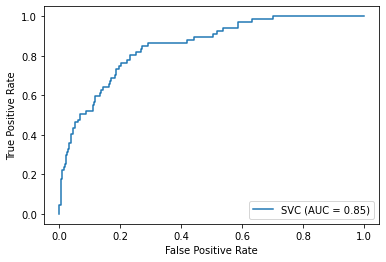

In [9]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
svm = SVC(C = 100, kernel = 'linear')
svm.fit(X_train, y_train)
plot_roc_curve(svm, X_test, y_test)
plt.show()

# results
The model was first tested on accuracy where the SVM scored a 0.84 (ROC AUC 0.85) and the Naive scored 0.78.


In [8]:
print('SVM recall score:{}'.format(recall_score(y_test, svm_grid.predict(X_test))))
print('Naïve recall score:{}'.format(recall_score(y_test, nb.predict(X_test))))

SVM recall score:0.5074626865671642
Naïve recall score:0.5671641791044776


# evaluatie
The SVM was as expected better when it came to the accuracy of the model, but when using the recall apparently naive bayes scores better. The scores also are drastically lower on the recall than the accuracy, which means that it predicts a lot of false negatives compared to the false positives.